## Introduce Residual Blocks on Unet architecture 

https://medium.com/@nishanksingla/unet-with-resblock-for-semantic-segmentation-dd1766b4ff66

In [1]:
import sys
sys.path.append('/'.join(sys.path[0].split('/')[:-1]))
import pygsp
import numpy as np

import torch
from torch.nn import functional as F
from torch.nn import BatchNorm1d, BatchNorm2d, Conv1d

from deepsphere.utils.samplings import equiangular_dimension_unpack

from modules.layers import (ConvCheb, PoolMaxHealpix, UnpoolMaxHealpix,
                            ConvChebTemp, PoolMaxTempHealpix, UnpoolMaxTempHealpix)

from modules.healpix_models import Conv1dAuto, UNetSphericalHealpixResidual, \
_compute_laplacian_healpix, ConvBlock, ConvCheb

In [2]:
class UNetSphericalHealpixResidual_2(torch.nn.Module):
    """Spherical GCNN UNet
    
     Parameters
    ----------
    N : int
        Number of nodes in the input graph
    in_channels : int
        Number of channels in the input graph.
    out_channels : int
        Number of channels in the output graph.
    kernel_size : int
        Chebychev polynomial degree
    """

    def __init__(self, N, in_channels, out_channels, kernel_size):        
        super().__init__()

        self.kernel_size = kernel_size
       
        laplacians = []
        for i, nodes in enumerate([3072, 768, 192]):
            laplacian = _compute_laplacian_healpix(nodes)
            laplacians.append(laplacian)
        
        
        # Pooling - unpooling
        self.pooling = PoolMaxHealpix(kernel_size=4)
        self.unpool = UnpoolMaxHealpix(kernel_size=4)
        
        # Encoding block 1
        self.conv11 = ConvBlock(in_channels, max(in_channels, 64), kernel_size, laplacians[0])
        self.conv12 = ConvBlock(max(in_channels, 64), max(in_channels, 64), kernel_size, laplacians[0])
        self.conv13 = ConvCheb(max(in_channels, 64), max(in_channels, 64), kernel_size, laplacians[0])#ConvBlock(max(in_channels, 32), 64, kernel_size, laplacians[0])
        
        self.conv1_res = Conv1dAuto(in_channels, 64, 1)
        
        # Encoding block 2
        self.conv21 = ConvBlock(64, 128, kernel_size, laplacians[1])
        self.conv22 = ConvBlock(128, 128, kernel_size, laplacians[1])
        self.conv23 = ConvCheb(128, 128, kernel_size, laplacians[1])
        
        self.conv2_res = Conv1dAuto(64, 128, 1)
       
        # Encoding block 3
        self.conv31 = ConvBlock(128, 256, kernel_size, laplacians[2])
        self.conv32 = ConvBlock(256, 256, kernel_size, laplacians[2])
        self.conv33 = ConvCheb(256, 128, kernel_size, laplacians[2])
        
        self.conv3_res = Conv1dAuto(128, 128, 1)
        
        # Decoding block 4
        self.uconv21 = ConvBlock(256, 128, kernel_size, laplacians[1])
        self.uconv22 = ConvBlock(128, 64, kernel_size, laplacians[1])
        
        # Decoding block 4
        self.uconv11 = ConvBlock(128, 64, kernel_size, laplacians[0])
        self.uconv12 = ConvBlock(64, 32, kernel_size, laplacians[0])
        self.uconv13 = ConvCheb(32, out_channels, kernel_size, laplacians[0])
        
         
    def encode(self, x):
        """ Encodes an input into a lower dimensional space applying convolutional, batch normalisation and pooling layers
        Parameters
        ----------
        x : torch.Tensor of shape batch_size x n_vertices x in_channels
            Input data
        Returns
        -------
       x_enc3, x_enc2, x_enc1, idx2, idx1 : torch.Tensors of shapes batch_size x n_vertices x layer_channels + list(int)
            Encoded data at the different encoding stages and the indices indicating the locations of the maxium values in
            unpooled images.
        """
        #x_enc1 = self.dropout1(x_enc1)
        
        # Block 1
        
        x_enc1 = self.conv11(x)
        x_enc1 = self.conv12(x_enc1)
        x_enc1 = self.conv13(x_enc1)
        
        x_enc1 += torch.transpose(self.conv1_res(torch.transpose(x, 2,1)), 2,1)
        x_enc1 = F.relu(x_enc1)
        #x_enc1 += self.conv1_res(x.transpose(0,2,1)).transpose(0,2,1)
        
        # Block 2
        x_enc2_ini, idx1 = self.pooling(x_enc1)
        x_enc2 = self.conv21(x_enc2_ini)
        x_enc2 = self.conv22(x_enc2)
        x_enc2 = self.conv23(x_enc2)
        
        x_enc2 += torch.transpose(self.conv2_res(torch.transpose(x_enc2_ini, 2,1)),2,1)
        x_enc2 = F.relu(x_enc2)
        #x_enc2 += self.conv2_res(x_enc1.transpose(0,2,1)).transpose(0,2,1)
        
        # Block 3
        x_enc3_ini, idx2 = self.pooling(x_enc2)
        x_enc3 = self.conv31(x_enc3_ini)
        x_enc3 = self.conv32(x_enc3)
        x_enc3 = self.conv33(x_enc3)
        x_enc3 += torch.transpose(self.conv3_res(torch.transpose(x_enc3_ini, 2,1)),2,1)
        x_enc3 = F.relu(x_enc3)
        #x_enc3 += self.conv3_res(x_enc2.transpose(0,2,1)).transpose(0,2,1)
        
        return x_enc3, x_enc2, x_enc1, idx2, idx1
    
    def decode(self, x_enc3, x_enc2, x_enc1, idx2, idx1):
        """ Decodes low dimensional data into high dimensional applying convolutional, batch normalisation, 
        unpooling layers and skip connections
        
        Parameters
        ----------
        x_enc3, x_enc2, x_enc1, idx2, idx1 : torch.Tensors of shapes batch_size x n_vertices x layer_channels + list(int)
            Encoded data at the different encoding stages and the indices indicating the locations of the maxium values in
            unpooled images.
        Returns
        -------
        x : torch.Tensor of shape batch_size x n_vertices x out_channels
            Decoded data
        """

        # Block 2
        x = self.unpool(x_enc3, idx2)
        x = torch.cat((x, x_enc2), dim=2)
        x = self.uconv21(x)
        x = self.uconv22(x)
        
        # Block 1
        x = self.unpool(x, idx1)
        x = torch.cat((x, x_enc1), dim=2)
        x = self.uconv11(x)
        x = self.uconv12(x)
        x = self.uconv13(x)
            
        return x
    
    def state_dict(self, *args, **kwargs):
        """
        This function overrides the state dict in order to be able to save the model.
        This can be removed as soon as saving sparse matrices has been added to Pytorch.
        """
        state_dict = super().state_dict(*args, **kwargs)
        del_keys = []
        for key in state_dict:
            if "laplacian" in key:
                del_keys.append(key)
        for key in del_keys:
            del state_dict[key]
        return state_dict

    def forward(self, x):
        """Forward Pass
        Parameters
        ----------
        x : torch.Tensor of shape batch_size x n_vertices x in_channels
            Input data
        Returns
        -------
        x : torch.Tensor of shape batch_size x n_vertices x out_channels
            Model output
        """
        x_encoded = self.encode(x)
        output = self.decode(*x_encoded)
        return output

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('/'.join(sys.path[0].split('/')[:-1]))

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import healpy as hp
import random

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from modules.utils import train_model_2steps_temp, init_device
from modules.data import WeatherBenchDatasetXarrayHealpixTemp
from modules.healpix_models import UNetSphericalHealpix, UNetSphericalTempHealpix
from modules.test import create_iterative_predictions_healpix_temp, compute_rmse_healpix
from modules.plotting import plot_rmses

datadir = "../data/healpix/"
input_dir = datadir + "5.625deg_nearest/"
model_save_path = datadir + "models/"
pred_save_path = datadir + "predictions/"

if not os.path.isdir(model_save_path):
    os.mkdir(model_save_path)
    
if not os.path.isdir(pred_save_path):
    os.mkdir(pred_save_path)

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
chunk_size = 521

train_years = ('1979', '2012')#('1979', '2012')
val_years = ('2013', '2016')
test_years = ('2017', '2018')

nodes = 12*16*16
max_lead_time = 5*24
nb_timesteps = 2

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"
gpu = [0]
num_workers = 10
pin_memory = True

nb_epochs = 20
learning_rate = 8e-3

obs = xr.open_mfdataset(pred_save_path + 'observations_nearest.nc', combine='by_coords', chunks={'time':chunk_size})
rmses_weyn = xr.open_dataset(datadir + 'metrics/rmses_weyn.nc')

In [7]:
from modules.data import WeatherBenchDatasetIterative
class WeatherBenchDatasetXarrayHealpixTemp(Dataset):
    
    """ Dataset used for graph models (1D), where data is loaded from stored numpy arrays.
    
    Parameters
    ----------
    ds : xarray Dataset
        Dataset containing the input data
    out_features : int
        Number of output features
    delta_t : int
        Temporal spacing between samples in temporal sequence (in hours)
    len_sqce : int
        Length of the input and output (predicted) sequences
    years : tuple(str)
        Years used to split the data
    nodes : float
        Number of nodes each sample has
    max_lead_time : int
        Maximum lead time (in case of iterative predictions) in hours
    load : bool
        If true, load dataset to RAM
    mean : np.ndarray of shape 2
        Mean to use for data normalization. If None, mean is computed from data
    std : np.ndarray of shape 2
        std to use for data normalization. If None, mean is computed from data
    """
        
    def __init__(self, ds, out_features, delta_t, len_sqce, years, nodes, nb_timesteps, 
                 max_lead_time=None, load=True, mean=None, std=None):
        
        
        self.delta_t = delta_t
        self.len_sqce = len_sqce
        self.years = years
        
        self.nodes = nodes
        self.out_features = out_features
        self.max_lead_time = max_lead_time
        self.nb_timesteps = nb_timesteps
        
        self.data = ds.to_array(dim='level', name='Dataset').transpose('time', 'node', 'level')
        self.in_features = self.data.shape[-1]
        
        self.mean = self.data.mean(('time', 'node')).compute() if mean is None else mean
        self.std = self.data.std(('time', 'node')).compute() if std is None else std
        
        eps = 0.001 #add to std to avoid division by 0
        
        # Count total number of samples
        total_samples = self.data.shape[0]        
        
        if max_lead_time is None:
            self.n_samples = total_samples - (len_sqce+1) * delta_t
        else:
            self.n_samples = total_samples - (len_sqce+1) * delta_t - max_lead_time
        
        # Normalize
        self.data = (self.data - self.mean.to_array(dim='level')) / (self.std.to_array(dim='level') + eps)
        self.data.persist()
        
        self.idxs = np.array(range(self.n_samples))
        
        print('Loading data to RAM...')
        t = time.time()
        self.data.load()
        print('Time: {:.2f}s'.format(time.time() - t))
        
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        """ Returns sample and label corresponding to an index as torch.Tensor objects
            The return tensor shapes are (for the sample and the label): [n_vertex, len_sqce, n_features]
            
        """
        idx_data = idx#self.idxs[idx]
        #1,0,2
        
        #batch[0] --> (batch_size, num_nodes, n_features*len_sq)
        idx_full = np.concatenate([idx_data+delta_t,  idx_data + delta_t * len_sqce, idx_data + delta_t * (len_sqce+1)])
        dat = self.data.isel(time=idx_full).values
        
        
        X = (
            torch.tensor(dat[:len(idx),:,:] , \
                         dtype=torch.float).reshape(len(idx), self.nodes, -1),
        )
        
        y = (torch.tensor(dat[len(idx):len(idx)*2,:,:],\
                         dtype=torch.float).reshape(len(idx), self.nodes, -1),\
             torch.tensor(dat[len(idx)*2:,:,:out_features],\
                         dtype=torch.float).reshape(len(idx), self.nodes, -1)
        
        )
        return X, y 

In [8]:
z500 = xr.open_mfdataset(f'{input_dir}geopotential_500/*.nc', combine='by_coords', chunks={'time':chunk_size}).rename({'z':'z500'})
t850 = xr.open_mfdataset(f'{input_dir}temperature_850/*.nc', combine='by_coords', chunks={'time':chunk_size}).rename({'t':'t850'})
rad = xr.open_mfdataset(f'{input_dir}toa_incident_solar_radiation/*.nc', combine='by_coords', chunks={'time':chunk_size})

z500 = z500.isel(time=slice(7, None))
t850 = t850.isel(time=slice(7, None))

constants = xr.open_dataset(f'{input_dir}constants/constants_5.625deg_standardized.nc')

orog = constants['orog']
lsm = constants['lsm']
lats = constants['lat2d']
slt = constants['slt']
cos_lon = constants['cos_lon']
sin_lon = constants['sin_lon']

num_constants = len([orog, lats, lsm, slt])
constants_tensor = torch.tensor(xr.merge([orog, lats, lsm, slt], compat='override').to_array().values, \
                            dtype=torch.float)

In [9]:
ds = xr.merge([z500, t850, rad], compat='override')
#ds = xr.merge([z500, t850, orog, lats, lsm, slt, rad], compat='override')

ds_train = ds.sel(time=slice(*train_years))
ds_valid = ds.sel(time=slice(*val_years))
ds_test = ds.sel(time=slice(*test_years))

In [10]:
#constants_tensor = (constants_tensor - torch.mean(constants_tensor, dim=1).view(-1,1).expand(4, 3072)) / torch.std(constants_tensor, dim=1).view(-1,1).expand(4, 3072)

In [11]:
train_mean_ = xr.open_mfdataset(f'{input_dir}mean_train_features_dynamic.nc')
train_std_ = xr.open_mfdataset(f'{input_dir}std_train_features_dynamic.nc')

In [12]:
len_sqce = 2
# define time resolution
delta_t = 6

# predict 5days data
max_lead_time = 5*24
in_features = 7
out_features = 2

batch_size = 100

In [13]:
description = "all_const_len1_delta6_resblock_new"

model_filename = model_save_path + "spherical_unet_" + description + ".h5"
pred_filename = pred_save_path + "spherical_unet_" + description + ".nc"
rmse_filename = datadir + 'metrics/rmse_' + description + '.nc'

In [14]:
# Train and validation data
training_ds = WeatherBenchDatasetXarrayHealpixTemp(ds=ds_train, out_features=out_features, delta_t=delta_t,
                                                   len_sqce=len_sqce, max_lead_time=max_lead_time,
                                                   years=train_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                   mean=train_mean_, std=train_std_, load=False)
validation_ds = WeatherBenchDatasetXarrayHealpixTemp(ds=ds_valid, out_features=out_features, delta_t=delta_t,
                                                     len_sqce=len_sqce, max_lead_time=max_lead_time,
                                                     years=val_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                     mean=train_mean_, std=train_std_, load=False)



Loading data to RAM...
Time: 48.03s
Loading data to RAM...
Time: 5.36s


In [15]:
def train_model_2steps(model, device, training_ds, constants, batch_size, epochs, lr, validation_ds):    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, eps=1e-7, weight_decay=0, amsgrad=False)
    
    train_losses = []
    val_losses = []
    n_samples = training_ds.n_samples
    n_samples_val = validation_ds.n_samples
    num_nodes = training_ds.nodes
    num_constants = constants.shape[1]
    out_features = training_ds.out_features
    
    constants_expanded = constants.expand(batch_size, num_nodes, num_constants)
    constants1 = constants_expanded.to(device)
    idxs_val = validation_ds.idxs
    
    for epoch in range(epochs):
        
        print('\rEpoch : {}'.format(epoch), end="")
        
        time1 = time.time()
        
        val_loss = 0
        train_loss = 0
        
        model.train()  
        
        random.shuffle(training_ds.idxs)
        idxs = training_ds.idxs
        
        batch_idx = 0
        
        for i in range(0, n_samples - batch_size, batch_size):
            i_next = min(i + batch_size, n_samples)
            
            if len(idxs[i:i_next]) < batch_size:
                constants_expanded = contants.expand(len(idxs[i:i_next]), num_nodes, num_constants)
                constants1 = constants_expanded.to(device)
        
            
            #t1 = time.time()
            batch, labels = training_ds[idxs[i:i_next]]
            
            #t2 = time.time()
            
            # Transfer to GPU
            batch1 = torch.cat((batch[0], constants_expanded), dim=2).to(device)
            label1 = labels[0].to(device)
            label2 = labels[1].to(device)
            
            
            #t3 = time.time()
            batch_size = batch1.shape[0]
            
            # Model
            
            #t4 = time.time()
            output1 = model(batch1)  
            #t5 = time.time()
            batch2 = torch.cat((output1, label1[:,:,-1].view(-1, num_nodes, 1), constants1), dim=2)
            #t6 = time.time()
            output2 = model(batch2)
            #t7 = time.time()
            loss = criterion(output1, label1[:,:,:out_features]) + criterion(output2, label2)
            #t8 = time.time()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + loss.item() * batch_size
            
            
            #print('\nTime to read batch: {}s'.format(t2-t1))
            #print('Time to transfer data to GPU: {}s'.format(t3-t2))
            #print('Time to process input 1: {}s'.format(t5-t4))
            #print('Time to process input 2: {}s'.format(t7-t6))
            #print('Time to compute loss: {}s'.format(t8-t7))
            #print('\n')
            print('\rBatch idx: {}; Loss: {:.3f}'.format(batch_idx, train_loss/(batch_size*(batch_idx+1))), end="")
            batch_idx += 1
        
        train_loss = train_loss / n_samples
        train_losses.append(train_loss)
        
        model.eval()
        
        constants1 = constants_expanded.to(device)
        with torch.set_grad_enabled(False):
            index = 0
            
            for i in range(0, n_samples_val - batch_size, batch_size):
                i_next = min(i + batch_size, n_samples_val)

                if len(idxs_val[i:i_next]) < batch_size:
                    constants_expanded = contants.expand(len(idxs_val[i:i_next]), num_nodes, num_constants)
                    constants1 = constants_expanded.to(device)


                #t1 = time.time()
                batch, labels = validation_ds[idxs_val[i:i_next]]
                # Transfer to GPU
                batch1 = torch.cat((batch[0], constants_expanded), dim=2).to(device)
                label1 = labels[0].to(device)
                label2 = labels[1].to(device)

                batch_size = batch1.shape[0]
                
                output1 = model(batch1)
                batch2 = torch.cat((output1, label1[:,:,-1].view(-1, num_nodes, 1), constants1), dim=2)
                output2 = model(batch2)
                
                val_loss = val_loss + (criterion(output1, label1[:,:,:out_features]).item() 
                                       + criterion(output2, label2).item()) * batch_size
                index = index + batch_size
                
        val_loss = val_loss / n_samples_val
        val_losses.append(val_loss)
        
        time2 = time.time()
        
        # Print stuff
        print('Epoch: {e:3d}/{n_e:3d}  - loss: {l:.3f}  - val_loss: {v_l:.5f}  - time: {t:2f}'
              .format(e=epoch+1, n_e=epochs, l=train_loss, v_l=val_loss, t=time2-time1))
        
    return train_losses, val_losses

In [16]:
spherical_unet = UNetSphericalHealpixResidual_2(N=nodes, in_channels=in_features, out_channels=out_features, kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)


In [17]:
train_loss, val_loss = train_model_2steps(spherical_unet, device, training_ds, constants_tensor.transpose(1,0), \
                                          batch_size=100, epochs=7, \
                                           lr=learning_rate, validation_ds=validation_ds)


Batch idx: 2978; Loss: 0.126Epoch:   1/  7  - loss: 0.126  - val_loss: 0.09323  - time: 4466.636147
Batch idx: 2978; Loss: 0.063Epoch:   2/  7  - loss: 0.063  - val_loss: 0.06450  - time: 4436.901942
Batch idx: 2978; Loss: 0.057Epoch:   3/  7  - loss: 0.057  - val_loss: 0.06138  - time: 4425.474988
Batch idx: 2978; Loss: 0.054Epoch:   4/  7  - loss: 0.054  - val_loss: 0.07699  - time: 4420.480421
Batch idx: 2978; Loss: 0.052Epoch:   5/  7  - loss: 0.052  - val_loss: 0.05350  - time: 4416.705603
Batch idx: 2978; Loss: 0.050Epoch:   6/  7  - loss: 0.050  - val_loss: 0.05495  - time: 4412.377114
Batch idx: 2978; Loss: 0.049Epoch:   7/  7  - loss: 0.049  - val_loss: 0.05552  - time: 4411.417215


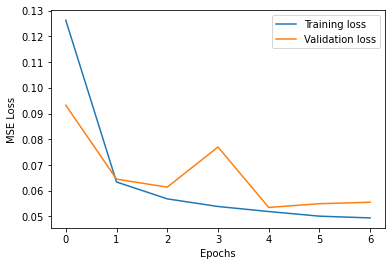

In [18]:
# Show training losses
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

del training_ds, validation_ds
torch.cuda.empty_cache()

In [19]:
# Testing data
testing_ds = WeatherBenchDatasetXarrayHealpixTemp(ds=ds_test, out_features=out_features,
                                                  len_sqce=len_sqce, delta_t=delta_t, years=test_years, 
                                                  nodes=nodes, nb_timesteps=nb_timesteps, 
                                                  mean=train_mean_, std=train_std_, 
                                                  max_lead_time=max_lead_time)


Loading data to RAM...
Time: 2.31s


In [20]:
def create_iterative_predictions_healpix_temp(model, device, dg, constants):
    
    out_feat = dg.out_features
    
    train_std =  dg.std[['z500','t850']].to_array().values #dg.std.values[:out_feat]
    train_mean = dg.mean[['z500','t850']].to_array().values #dg.mean.values[:out_feat]
    
    delta_t = dg.delta_t
    len_sqce = dg.len_sqce
    max_lead_time = dg.max_lead_time
    initial_lead_time = delta_t * len_sqce
    nodes = dg.nodes
    nside = int(np.sqrt(nodes/12))
    n_samples = dg.n_samples
    in_feat = 2#dg.in_features
    num_constants = constants.shape[1]
    
    batch_size = 10
    # Lead times
    lead_times = np.arange(delta_t, max_lead_time + delta_t, delta_t)
    
    # Lat lon coordinates
    out_lon, out_lat = hp.pix2ang(nside, np.arange(nodes), lonlat=True)
    
    # Actual times
    start = np.datetime64(dg.years[0], 'h') + np.timedelta64(initial_lead_time, 'h')
    stop = start + np.timedelta64(dg.n_samples, 'h')
    times = np.arange(start, stop)
    
    # Variables
    var_dict_out = {var: None for var in ['z', 't']}
    
    # Constants
    constants_expanded = constants.expand(batch_size, nodes, num_constants)
    constants1 = constants_expanded.to(device)
    idxs = dg.idxs
    
    
    dataloader = dg
    predictions = []
    model.eval()
    for num_lead, lead in enumerate(lead_times):
        print('\rProcessing lead time {} out of {}'.format(num_lead+1, len(lead_times)), end="")
        outputs = []
        
        time1 = time.time()
        
        for i in range(0, n_samples - batch_size, batch_size):
            i_next = min(i + batch_size, n_samples)

            if len(idxs[i:i_next]) < batch_size:
                constants_expanded = contants.expand(len(idxs[i:i_next]), num_nodes, num_constants)
                constants1 = constants_expanded.to(device)
            
            batch, _ = dg[idxs[i:i_next]]
            if num_lead == 0:
                inputs = torch.cat((batch[0], constants_expanded), dim=2).to(device)
                # first time use real obs as input
                 
            else:
                # after first prediction start using output as new input for future predictions
                inputs = torch.cat((torch.tensor(preds[i:i_next,:,:]), \
                                    batch[0][:,:,-1].reshape(batch_size, nodes,1), \
                                    constants_expanded), dim=2).to(device)
            
            output = model(inputs)
            
            
            #next_batch_.append(inputs[:, :, in_feat:].detach().cpu().clone().numpy())
            outputs.append(output.detach().cpu().clone().numpy()[:, :, :out_feat])
            
            
        #next_batch = np.concatenate(next_batch_)    
        preds = np.concatenate(outputs)
        predictions.append(preds * train_std + train_mean)

        """
        for i, (sample, _) in enumerate(dataloader):
            inputs = sample[0].to(device)
            output = model(inputs)
            
            next_batch_.append(inputs[:, :, in_feat:].detach().cpu().clone().numpy())
            outputs.append(output.detach().cpu().clone().numpy()[:, :, :out_feat])
            
            
        next_batch = np.concatenate(next_batch_)    
        preds = np.concatenate(outputs)
        states[:, :, :(len_sqce-1)*in_feat] = next_batch
        states[:, :, (len_sqce-1)*in_feat:(len_sqce-1)*in_feat + out_feat] = preds
        states[:, :, -(in_features - out_features):] =  constants[(len_sqce-1)*delta_t+
                                                                  lead:n_samples+(len_sqce-1)*delta_t+lead, :]

        predictions.append(preds * train_std + train_mean)

        new_set = WeatherBenchDatasetIterative(states)
        dataloader = DataLoader(new_set, batch_size=batch_size, shuffle=False, num_workers=10)
        """
        time2 = time.time()
        
    predictions = np.array(predictions)
    
    return predictions, lead_times, times, nodes, out_lat, out_lon
    das = [];
    lev_idx = 0
    for var in ['z', 't']:       
        das.append(xr.DataArray(
            predictions[:, :, :, lev_idx],
            dims=['lead_time', 'time', 'node'],
            coords={'lead_time': lead_times, 'time': times, 'node': np.arange(nodes)},
            name=var
        ))
        lev_idx += 1
            
    prediction_ds = xr.merge(das)
    prediction_ds = prediction_ds.assign_coords({'lat': out_lat, 'lon': out_lon})
    return prediction_ds

In [21]:
torch.cuda.empty_cache() 

In [22]:
predictions, lead_times, times, nodes, out_lat, out_lon = \
create_iterative_predictions_healpix_temp(spherical_unet, device, testing_ds, constants_tensor.transpose(1,0))

Processing lead time 20 out of 20

In [23]:
das = [];
lev_idx = 0
for var in ['z', 't']:       
    das.append(xr.DataArray(
        predictions[:, :, :, lev_idx],
        dims=['lead_time', 'time', 'node'],
        coords={'lead_time': lead_times, 'time': times[:-2], 'node': np.arange(nodes)},
        name=var
    ))
    lev_idx += 1

prediction_ds = xr.merge(das)
prediction_ds = prediction_ds.assign_coords({'lat': out_lat, 'lon': out_lon})

In [24]:
prediction_ds.to_netcdf(pred_filename)

In [25]:
# Compute and save RMSE
rmse = compute_rmse_healpix(prediction_ds, obs).load()
rmse.to_netcdf(rmse_filename)

# Show RMSE
print('Z500 - 0:', rmse.z.values[0])
print('T850 - 0:', rmse.t.values[0])


Z500 - 0: 82.69103248687263
T850 - 0: 0.7305409342812357


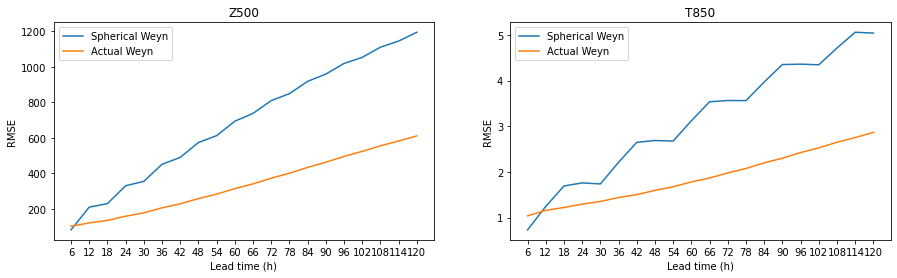

In [26]:
plot_rmses(rmse, rmses_weyn.rename({'z500':'z', 't850':'t'}).isel(lead_time=list(range(20))), lead_time=6)

del spherical_unet, prediction_ds, rmse
torch.cuda.empty_cache()